# P1 - TSA - Acceso a Internet en Colombia

Elaborado por GRUPO 1:
- Juanita Piraban Barbosa - 201216313
- Lorena Morales Rodríguez - 202027957
- Alejandro Barinas Guio - 201628859
- Jaime Humberto Trujillo Perea - 201920366
- Alexander Zapata Galindo - 201425426

In [1]:
# Importar Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sys
import plotly as pt
import plotly.express as px
import warnings

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from matplotlib import pyplot
from pandas import DatetimeIndex
from pandas import Series
from tabulate import tabulate

%matplotlib inline
sns.set()  

In [2]:
# Leer el archivo 'datos.csv'
df = pd.read_excel("DataSet/P1_Serie_Acceso_Internet_Trim.xlsx",index_col=0)

# Parte A. Contexto y relevancia del problema

### $\color{red}{\text{TODOS}}$ 

Para el desarrollo del proyecto, se utilizó la serie de tiempo del porcentaje de penetración de Internet dedicado en Colombia (% de la población).

Número de suscriptores con acceso a Internet, fijo y móvil, según los datos reportados por los proveedores al último día de cada trimestre como porcentaje de la población basados en las proyecciones de población del DANE.

Fuente: Ministerio de las TIC https://colombiatic.mintic.gov.co/

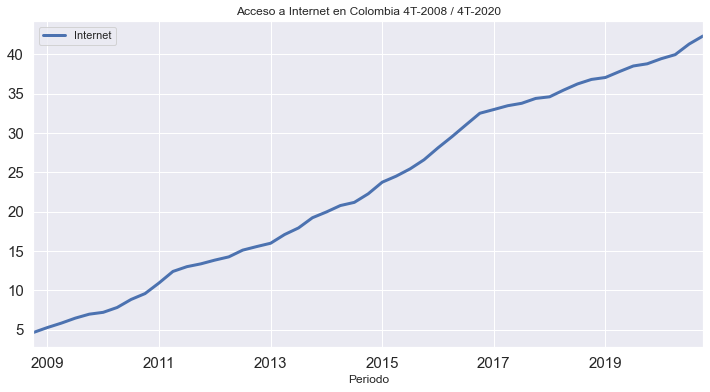

In [3]:
df.plot(figsize=(12, 6),linewidth=3, fontsize=15, title='Acceso a Internet en Colombia 4T-2008 / 4T-2020');

In [4]:
df.Internet.describe()

count    49.000000
mean     23.267556
std      11.852783
min       4.633165
25%      13.362776
50%      22.276354
75%      34.406101
max      42.350991
Name: Internet, dtype: float64

In [5]:
table_Latam = [['Colombia','64.1%'],['Argentina','68.2%'],['Brasil','70.4%'],['México','65.8%'],['Perú','55.1%'],['Uruguay','74.8%']]
headers = ['País', 'año 2018']
print(tabulate(table_Latam,headers))

País       año 2018
---------  ----------
Colombia   64.1%
Argentina  68.2%
Brasil     70.4%
México     65.8%
Perú       55.1%
Uruguay    74.8%


In [6]:
table_GP = [['Alemania','87.0%'],['China','90.5%'],['Estados Unidos','88.5%'],['Japón','91.3%'],['OECD','82.8%'],['Reino Unido','90.7%']]
headers = ['País', 'año 2018']
print(tabulate(table_GP,headers))

País            año 2018
--------------  ----------
Alemania        87.0%
China           90.5%
Estados Unidos  88.5%
Japón           91.3%
OECD            82.8%
Reino Unido     90.7%


# Parte B. Análisis de los principales componentes de la serie

### $\color{red}{\text{JAIME}}$ 

# Estacionariedad

In [5]:
#DF Test
result = adfuller(df['Internet'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.040810
p-value: 0.955024
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601


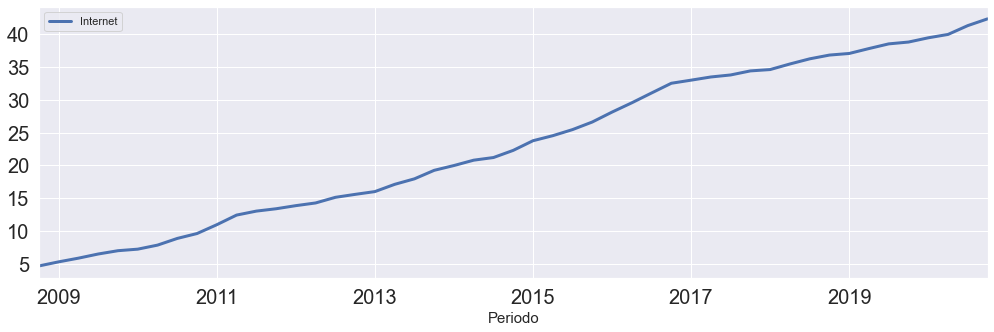

In [6]:
df.rolling(1).mean().plot(figsize=(17,5), linewidth=3, fontsize=20)
plt.xlabel('Periodo', fontsize=15);

En este caso, el test no rechaza la Ho de que la serie no es estacionaria.

# Tendencia

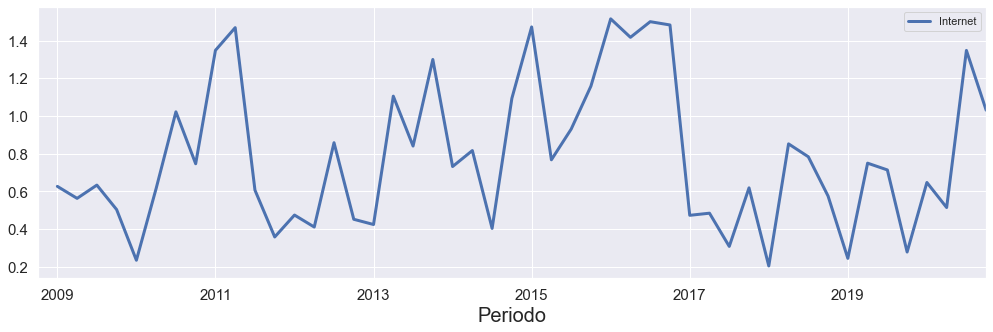

In [7]:
df.diff().plot(figsize=(17,5), linewidth=3, fontsize=15)
plt.xlabel('Periodo', fontsize=20);

In [8]:
result = adfuller(df['Internet'].diff().iloc [ 1 :]) 
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.179342
p-value: 0.000714
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601


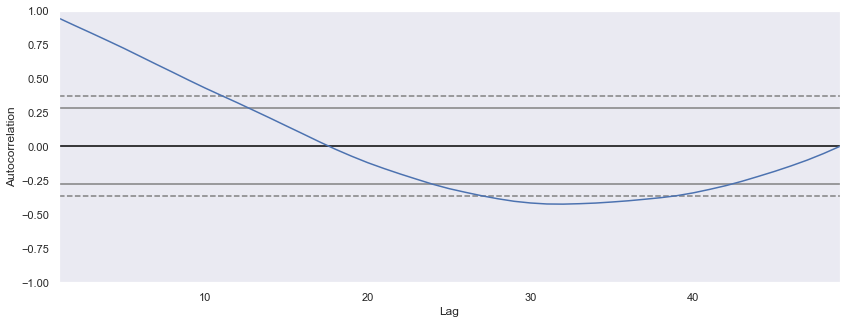

In [9]:
plt.figure(figsize=(14,5))
pd.plotting.autocorrelation_plot(df);

# Estacionalidad

# Parte C. Modelos y Proyecciones

In [19]:
warnings.filterwarnings('ignore')

## C.1. Modelos ARIMA

### $\color{red}{\text{JUANITA-ALEX}}$ 

## 1. Modelos

Se transforma la serie en logaritmo y se diferencia una vez:

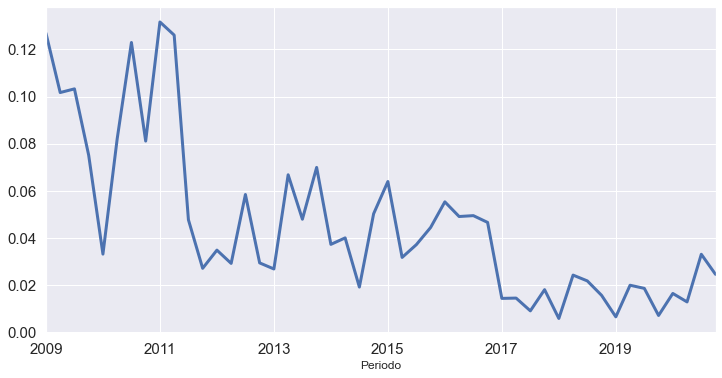

In [10]:
df['log_Internet'] = np.log(df['Internet'])
df_log=df.iloc[:,1:3]
df_log= df.log_Internet.diff()
df_log=df_log.dropna()
df_log.plot(figsize=(12, 6),linewidth=3, fontsize=15);

In [11]:
result = adfuller(df_log)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.297381
p-value: 0.014996
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601


La serie diferenciada una vez mas, es estacionaria. 

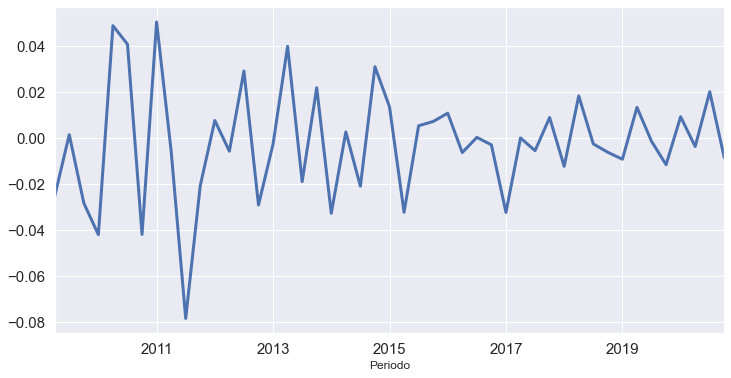

In [12]:
df_log_1= df_log.diff()
df_log_1=df_log_1.dropna()
df_log_1.plot(figsize=(12, 6),linewidth=3, fontsize=15);

In [13]:
result = adfuller(df_log_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.279510
p-value: 0.000000
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602


La serie es estacionaria, luego de las dos diferenciaciones anteriores.

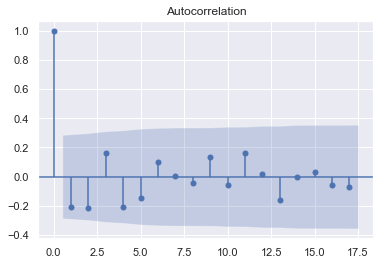

In [14]:
# Función de Autocorrelación (opción 1)
plot_acf(df_log_1);

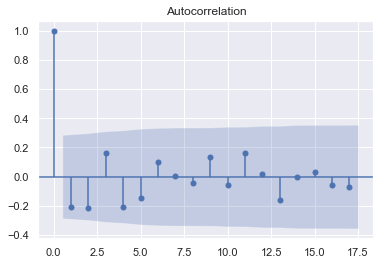

In [16]:
# Función de Autocorrelación (opción 2)
serie = np.log(df['Internet']).diff().diff().dropna()
plot_acf(serie);

In [19]:
#Función de Autocorrelación Parcial (opción 1)
#plot_pacf(df_log_1);

In [20]:
#Función de Autocorrelación Parcial (opción 2)
#plot_pacf(serie);

In [17]:
#Bases de train y test
X = df['Internet'].values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
future = [x for x in test]

In [20]:
# fit modelo 1 - ARIMA(2,2,1)
model1 = ARIMA(np.log(history), order=(2,2,1))
model1_fit = model1.fit(disp=0)
print(model1_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   37
Model:                 ARIMA(2, 2, 1)   Log Likelihood                  83.279
Method:                       css-mle   S.D. of innovations              0.025
Date:                Wed, 14 Jul 2021   AIC                           -156.558
Time:                        00:32:36   BIC                           -148.503
Sample:                             2   HQIC                          -153.718
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.003     -0.890      0.374      -0.009       0.003
ar.L1.D2.y    -0.7030      0.422     -1.667      0.096      -1.530       0.124
ar.L2.D2.y    -0.3581      0.152     -2.361      0.0

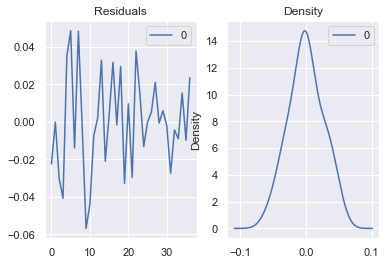

In [21]:
# plot residual errors
residuals = pd.DataFrame(model1_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

     predict       real
0  36.244266  36.247135
1  36.659009  36.822584
2  37.175699  37.067690
3  37.559639  37.817613
4  37.798745  38.531663
5  37.981876  38.810409
6  38.046359  39.457992
7  38.002094  39.972537
8  37.864124  41.320338
9  37.619497  42.350991


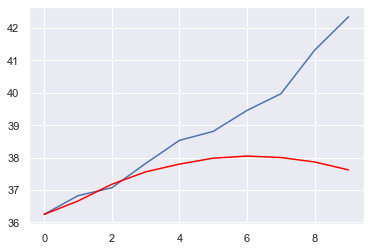

Test MSE: 4.154


In [22]:
# Real vs Proyectado
output = model1_fit.forecast(steps=len(test))[0]
yhat = output
predictions = np.exp(yhat)
real_values = future
print(pd.DataFrame({'predict':predictions, 'real':real_values}))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# MSE
mse1 = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse1)

In [23]:
# fit modelo 2 - ARIMA(3,2,0)
model2 = ARIMA(np.log(history), order=(3,2,0))
model2_fit = model2.fit(disp=0)
print(model2_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   37
Model:                 ARIMA(3, 2, 0)   Log Likelihood                  83.021
Method:                       css-mle   S.D. of innovations              0.026
Date:                Wed, 14 Jul 2021   AIC                           -156.042
Time:                        00:32:53   BIC                           -147.987
Sample:                             2   HQIC                          -153.202
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.003     -0.935      0.350      -0.009       0.003
ar.L1.D2.y    -0.2425      0.168     -1.448      0.148      -0.571       0.086
ar.L2.D2.y    -0.2590      0.161     -1.607      0.1

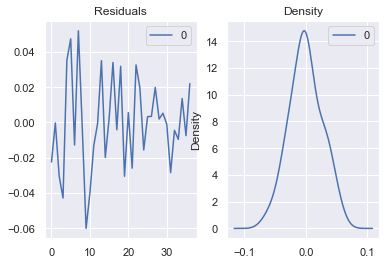

In [24]:
# plot residual errors
residuals = pd.DataFrame(model2_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

     predict       real
0  36.164496  36.247135
1  36.574458  36.822584
2  37.001840  37.067690
3  37.352344  37.817613
4  37.554695  38.531663
5  37.667058  38.810409
6  37.686213  39.457992
7  37.592864  39.972537
8  37.396620  41.320338
9  37.101740  42.350991


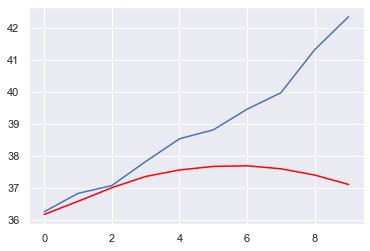

Test MSE: 5.430


In [25]:
#Real vs Proyectado
output = model2_fit.forecast(steps=len(test))[0]
yhat = output
predictions = np.exp(yhat)
real_values = future
print(pd.DataFrame({'predict':predictions, 'real':real_values}))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# MSE
mse2 = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse2)

In [26]:
# fit modelo 3 - ARIMA(0,2,1)
model3 = ARIMA(np.log(history), order=(0,2,1))
model3_fit = model3.fit(disp=0)
print(model3_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   37
Model:                 ARIMA(0, 2, 1)   Log Likelihood                  82.314
Method:                       css-mle   S.D. of innovations              0.026
Date:                Wed, 14 Jul 2021   AIC                           -158.628
Time:                        00:33:04   BIC                           -153.795
Sample:                             2   HQIC                          -156.924
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.002     -1.155      0.248      -0.007       0.002
ma.L1.D2.y    -0.4788      0.382     -1.254      0.210      -1.227       0.270
                                    Roots           

     predict       real
0  35.924483  36.247135
1  36.295094  36.822584
2  36.572195  37.067690
3  36.753597  37.817613
4  36.837858  38.531663
5  36.824309  38.810409
6  36.713058  39.457992
7  36.504989  39.972537
8  36.201753  41.320338
9  35.805743  42.350991


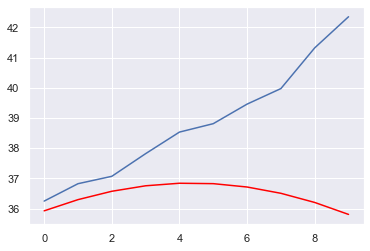

Test MSE: 9.717


In [27]:
#Real vs Proyectado
output = model3_fit.forecast(steps=len(test))[0]
yhat = output
predictions = np.exp(yhat)
real_values = future
print(pd.DataFrame({'predict':predictions, 'real':real_values}))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# MSE
mse3 = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse3)

In [28]:
# Comparación de MSE
table_MSE = [['ARIMA (2,2,1)', round(mse1,2)],['ARIMA (3,2,0)', round(mse2,2)],['ARIMA (0,2,1)', round(mse3,2)]]
headers = ['Modelo', 'MSE ']
print(tabulate(table_MSE,headers,stralign="decimal"))

       Modelo    MSE
-------------  ------
ARIMA (2,2,1)    4.15
ARIMA (3,2,0)    5.43
ARIMA (0,2,1)    9.72


Se selecciona el modelo ARIMA(2,2,1) por tener menor MSE.

## 2. Proyección a 1 año (fuera de la muestra)

In [29]:
#Modelo final con todos los datos
model_def = ARIMA(np.log(X), order=(2,2,1))
model_def_fit = model_def.fit(disp=0)
print(model_def_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   47
Model:                 ARIMA(2, 2, 1)   Log Likelihood                 113.376
Method:                       css-mle   S.D. of innovations              0.021
Date:                Wed, 14 Jul 2021   AIC                           -216.752
Time:                        00:33:58   BIC                           -207.501
Sample:                             2   HQIC                          -213.270
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.000     -5.369      0.000      -0.003      -0.001
ar.L1.D2.y     0.4792      0.149      3.218      0.001       0.187       0.771
ar.L2.D2.y    -0.1012      0.151     -0.671      0.5

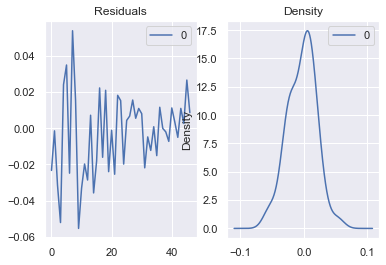

In [30]:
# plot residual errors
residuals = pd.DataFrame(model_def_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

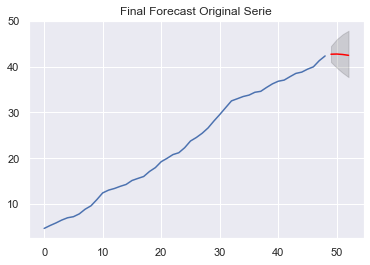

In [33]:
#Proyección por fuera de la muestra
n_periods = 4
fc, se, conf = model_def_fit.forecast(steps=n_periods)

#Extraer series
index_of_fc = np.arange(len(X), len(X)+n_periods)
fc_serie = np.exp(pd.Series(fc, index=index_of_fc))
lower_serie = np.exp(pd.Series(conf[:, 0], index=index_of_fc))
upper_serie = np.exp(pd.Series(conf[:, 1], index=index_of_fc))

# Gráfico
plt.plot(X)
plt.plot(fc_serie, color='red')
plt.fill_between(lower_serie.index,lower_serie, upper_serie, 
                 color='k', alpha=.15)
plt.title("Final Forecast Original Serie")
plt.show()

In [34]:
años=['1T-21','2T-21','3T-21','4T-21']
años=pd.DataFrame(años)
table_proy = [[años[-0],round(fc_serie[:],1), round(lower_serie,1), round(upper_serie,1)]]
headers = ['Año','Proyección', 'Límite inferior','Límite superior']
print(tabulate(table_proy,headers))

Año                     Proyección      Límite inferior    Límite superior
----------------------  --------------  -----------------  -----------------
0    1T-21              49    42.7      49    41.0         49    44.5
1    2T-21              50    42.8      50    39.7         50    46.0
2    3T-21              51    42.7      51    38.7         51    47.1
3    4T-21              52    42.5      52    37.7         52    47.9
Name: 0, dtype: object  dtype: float64  dtype: float64     dtype: float64


## C.2. Modelo Prophet

In [35]:
df['log_Internet'] = np.log(df['Internet'])
df_log=df.iloc[:,1:3]
df_log=df_log.dropna()
df2=df_log.iloc[:,]
df2.rename(columns=df2.iloc[0]).drop(df2.index[0])
df2.head()

,log_Internet
Periodo,
2008-12-31,1.533240
2009-03-31,1.660152
2009-06-30,1.761886
2009-09-30,1.865170
2009-12-31,1.940300


## 1. Modelo ###

In [38]:
df_log.columns = ['ds', 'y']
df_log.head()
m = Prophet()
m.fit(df_log)

ValueError: Length mismatch: Expected axis has 1 elements, new values have 2 elements

## 2. Proyección a 1 año (fuera de la muestra) ###

In [39]:
future = m.make_future_dataframe(periods=4, freq='TS')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

NameError: name 'm' is not defined

# Conclusiones

### $\color{red}{\text{TODOS}}$ 